In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import randint


In [58]:
df_for_ridge=pd.read_csv(r"C:\Users\User\Desktop\python projekty/used_cars_model_ready_ridge.csv")
df_for_rf=pd.read_csv(r"C:\Users\User\Desktop\python projekty/used_cars_model_ready_rf.csv")

All preprocessing steps that estimate parameters (such as scaling and encoding) are fitted exclusively on the training set to avoid data leakage.
Performing these operations before the train–test split would introduce information from the test set into the training process, leading to overly optimistic performance estimates.
Using model-specific preprocessing pipelines ensures a realistic evaluation and mirrors real-world deployment conditions.

In [59]:

TARGET = "sellingprice"

# ===========================
# RIDGE
X_ridge = df_for_ridge.drop(columns=[TARGET])
y_ridge = df_for_ridge[TARGET]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_ridge, y_ridge, test_size=0.2, random_state=42
)

# ===========================
# RANDOM FOREST
X_rf = df_for_rf.drop(columns=[TARGET])
y_rf = df_for_rf[TARGET]

Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42
)

# ===========================
print("Train Ridge set:", Xr_train.shape, yr_train.shape)
print("Test Ridge set:", Xr_test.shape, yr_test.shape)

print("Train RF set:", Xf_train.shape, yf_train.shape)
print("Test RF set:", Xf_test.shape, yf_test.shape)


Train Ridge set: (446370, 11) (446370,)
Test Ridge set: (111593, 11) (111593,)
Train RF set: (446370, 11) (446370,)
Test RF set: (111593, 11) (111593,)


In [60]:
# ===========================
num_cols = ["mmr", "odometer", "condition", "car_age", "miles_per_year", ] 
cat_cols_ridge = ["make", "body", "state", "color", "interior", "transmission"]
cat_cols_rf    = ["make", "body", "state", "color", "interior", "transmission"]
# ===========================
preprocess_ridge = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols_ridge),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ===========================
preprocess_rf = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OrdinalEncoder(
            handle_unknown="use_encoded_value",
            unknown_value=-1
        ), cat_cols_rf),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ===========================
pipe_ridge = Pipeline([("prep", preprocess_ridge)])
pipe_rf    = Pipeline([("prep", preprocess_rf)])


In [61]:
# ===========================
# RIDGE preprocessing
Xr_train_prep = pipe_ridge.fit_transform(Xr_train)
Xr_test_prep  = pipe_ridge.transform(Xr_test)

# ===========================
# RF preprocessing
Xf_train_prep = pipe_rf.fit_transform(Xf_train)
Xf_test_prep  = pipe_rf.transform(Xf_test)

In [62]:
print(Xr_train_prep.shape, Xr_test_prep.shape)
print(Xf_train_prep.shape, Xf_test_prep.shape)
print(yr_train.shape, yr_test.shape)
print(yf_train.shape, yf_test.shape)


(446370, 54) (111593, 54)
(446370, 11) (111593, 11)
(446370,) (111593,)
(446370,) (111593,)


In [63]:
ridge = Ridge()
param_grid_ridge = {
    "alpha": [0.1, 1.0, 10.0, 50.0, 100.0]
}

gs_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

gs_ridge.fit(Xr_train_prep, yr_train)

print(gs_ridge.best_params_, -gs_ridge.best_score_)
best_ridge = gs_ridge.best_estimator_

{'alpha': 100.0} 1205.786273494892


In [64]:
pred = best_ridge.predict(Xr_test_prep)


In [65]:

rf = RandomForestRegressor(random_state=42)

rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [20,30,40],
    "min_samples_split": [8,12],
    "min_samples_leaf": [4,5],
   # "max_features": ["sqrt", 0.7, 1.0]
}

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_grid,
    n_iter=15,                          
    cv=3,                               
    scoring="neg_mean_squared_error",   
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# UWAGA: trenuj na danych po preprocessingu RF
rf_random.fit(Xf_train_prep, yf_train)

print("Best params:", rf_random.best_params_)
print("Best CV score:", -rf_random.best_score_)
best_rf = rf_random.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best params: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 20}
Best CV score: 4099722.0539203086


In [67]:

pred = best_ridge.predict(Xr_test_prep)
rf_pred = best_rf.predict(Xf_test_prep)


In [68]:
def eval_reg(model, X_test, y_test, name="model"):
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = root_mean_squared_error(y_test, pred)
    print(f"{name}: MAE={mae:,.2f} | RMSE={rmse:,.2f}")

eval_reg(best_ridge, Xr_test_prep, yr_test, "Ridge tuned")
eval_reg(best_rf, Xf_test_prep, yf_test, "RF tuned")

Ridge tuned: MAE=1,213.08 | RMSE=2,684.87
RF tuned: MAE=991.72 | RMSE=1,993.28


A regularized linear model (Ridge regression) was used as a transparent baseline, with hyperparameters selected via cross-validation.
A Random Forest model was subsequently optimized using randomized search and achieved a substantial performance improvement, reducing test MAE by approximately 18%.
This indicates the presence of non-linear relationships in the data, making the tree-based model the final choice.

In [ ]:
feature_names = pipe_rf.named_steps["prep"].get_feature_names_out()

importances = best_rf.feature_importances_

fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

fi


,feature,importance
0,mmr,0.959959
1,condition,0.009322
2,miles_per_year,0.006867
3,make,0.006636
4,odometer,0.005993
5,state,0.002896
6,body,0.002549
7,car_age,0.002281
8,color,0.001892
9,interior,0.001312


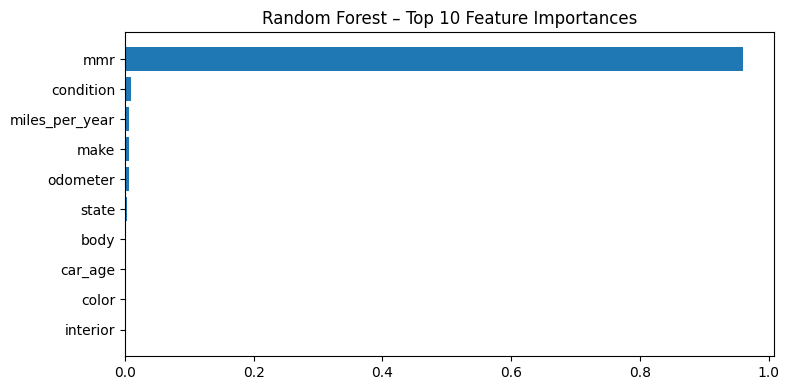

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Random Forest – Top 10 Feature Importances")
plt.tight_layout()
plt.show()


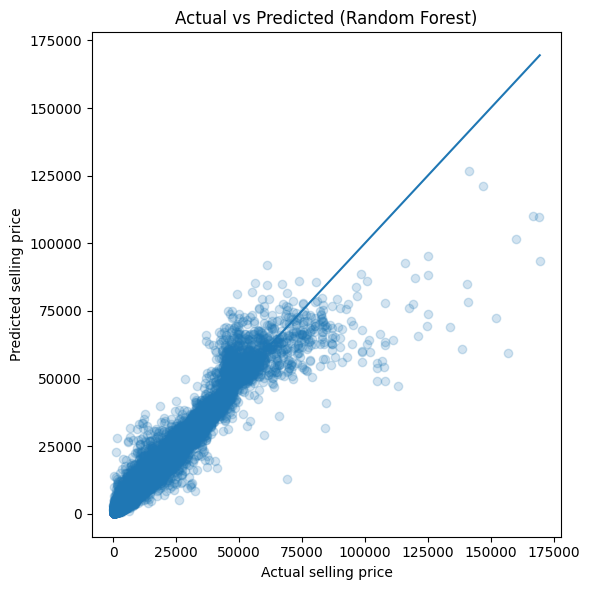

In [ ]:

y_true = yf_test
y_pred = best_rf.predict(Xf_test_prep)

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.2)

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val])

plt.title("Actual vs Predicted (Random Forest)")
plt.xlabel("Actual selling price")
plt.ylabel("Predicted selling price")
plt.tight_layout()
plt.show()
